In [3]:
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import tensorflow as tf
import struct 
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
!ls

LICENSE
README.md
Untitled-1
Untitled-1p
Untitled.ipynb
bug-fix.ipynb
ci
download_data.py
latest_helper.yml
linear_regression.1.ipynb
linear_regression.house.price.ipynb
lnv_build.yml
log
lr-13.png
mnist1
model.ops
model.py
model_tf.py
modelp
polyaxonfile.yml
polyaxonfile_declarations.yml
polyaxonfile_hyperparams.yml
polyaxonfile_hyperparams_bo.yml
polyaxonfile_hyperparams_early_stopping.yml
polyaxonfile_hyperparams_grid.yml
polyaxonfile_hyperparams_hyperband.yml
polyaxonfile_job.yml
polyaxonfile_notebook.yml
polyaxonfile_tensorboard.yml
predict.ckpt.py
predict.es.ipynb
predict.es.py
sgd_classifier.ipynb
t.ipynb
test.py
testcomment.py


####  数据路径存在虚拟主机路径下： /data/mnist 注意，客户端需要执行 polyaxon run -f job.yml


In [6]:
!ls /data/mnist

t10k-images-idx1-ubyte	   t10k-labels-idx1-ubyte.gz
t10k-images-idx3-ubyte	   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte


In [7]:
test_images = '/data/mnist/'
test_images
os.system('gunzip -c {} > {}'.format(test_images+ 't10k-images-idx3-ubyte.gz',test_images +'t10k-images-idx3-ubyte'))
os.system('gunzip -c {} > {}'.format(test_images + 't10k-labels-idx1-ubyte.gz',test_images +'t10k-labels-idx1-ubyte'))
test_images

'/data/mnist/'

#加载数据的路径
#path='./dataset/mnist/raw'

In [8]:
import struct

def load_mnist_train(path, kind='train'):    
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    return images, labels


def load_mnist_test(images_path,labels_path):

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    return images, labels 

In [9]:
test_images

'/data/mnist/'

In [10]:
test_images_path= os.path.join(test_images,'t10k-images-idx3-ubyte')
test_labels_path= os.path.join(test_images, 't10k-labels-idx1-ubyte')

In [11]:

test_images=[]
test_labels=[]
test_images,test_labels=load_mnist_test(test_images_path,test_labels_path)
print(np.shape(test_images),np.shape(test_labels))

(10000, 784) (10000,)


Text(0.5,1,'7')

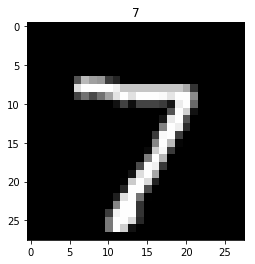

In [12]:
img_random = test_images[0,:].reshape(28,28)
plt.imshow(img_random,cmap=plt.cm.gray)
plt.title(test_labels[0])
plt.Text(0.5,1,'7')


#### 模型路径存在虚拟主机路径下： /outputs/root/quick-start1/experiments/5


In [13]:
modelpathpre = '/outputs/root//'
experiment  = 'quick-start1/'
exp_num = 'experiments/5/'

modelpath = modelpathpre + experiment  + exp_num
print(modelpath)

/outputs/root//quick-start1/experiments/5/


In [14]:
#没有？
asda =os.system('ls {}'.format(modelpath))
asda

0

In [15]:
!ls {modelpath}

checkpoint
eval
events.out.tfevents.1553656058.plx-d9f55b96b11b470083a5362839007717-master-0
graph.pbtxt
model.ckpt-1.data-00000-of-00001
model.ckpt-1.index
model.ckpt-1.meta
model.ckpt-430.data-00000-of-00001
model.ckpt-430.index
model.ckpt-430.meta


#### 重点来了，加载模型，读取模型

In [16]:
#tf.estimator  需要写网络的  
#用estimator加载
mode = tf.estimator.ModeKeys.PREDICT

In [27]:
def get_model_fn(dropout):
    """Create a `model_fn` compatible with tensorflow estimator based on hyperparams."""

    def get_network(x_dict, is_training):
        with tf.variable_scope('network'):
            x = x_dict['images']
            x = tf.reshape(x, shape=[-1, 28, 28, 1])
            conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
            conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
            conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
            conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
            fc1 = tf.contrib.layers.flatten(conv2)
            fc1 = tf.layers.dense(fc1, 1024)
            fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
            out = tf.layers.dense(fc1, 10)
        return out

    def model_fn(features, labels, mode):
        is_training = mode == tf.estimator.ModeKeys.TRAIN
        #is_training = 0
        results = get_network(features, is_training=is_training)

        predictions = tf.argmax(results, axis=1)

        # Return prediction
        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)
#             return tf.estimator.EstimatorSpec(mode, predictions=
#                                               {'predict':tf.argmax(predictions,1)})


                # Define loss
        loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=results, labels=tf.cast(labels, dtype=tf.int32)))
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())

        # Evaluation metrics
        accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
        precision = tf.metrics.precision(labels=labels, predictions=predictions)

        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=predictions,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': accuracy, 'precision': precision})

    return model_fn

In [28]:
estim = tf.estimator.Estimator(get_model_fn(dropout=0.),model_dir=modelpath)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_task_id': 0, '_session_config': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_tf_random_seed': None, '_service': None, '_task_type': 'worker', '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_is_chief': True, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f90a62739b0>, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/outputs/root//quick-start1/experiments/5/'}


In [29]:
img_random2 = img_random.reshape(1,784)
img_random2 =img_random2.astype(np.float32)
print(img_random2.dtype,np.shape(img_random2))

float32 (1, 784)


In [30]:
input_fn2 = tf.estimator.inputs.numpy_input_fn(
    x={'images': img_random2},
    y=None,
    batch_size=1,
    shuffle=False
)

In [31]:
#TypeError: 'str' object is not callable 一直报这个错误

pred = estim.predict(input_fn=input_fn2)
print(type(pred))
for p in pred:
    print(p)

<class 'generator'>
INFO:tensorflow:Restoring parameters from /outputs/root//quick-start1/experiments/5/model.ckpt-430
7
